# Image processing with OpenCV
## Basic use of EAST algorithm (without training)
***Objective:*** *to run the pre-trained EAST (Efficient and Accurate Scene Text recogniser.*

**Repository:** https://github.com/gbstringer/python-improc/

#### Import numpy, scikit-image and open computer vision libraries
* **numpy** (*) provides the matrix arithmetic (not currently used)
* **cv2** (opencv-python) provides the image processing functions
* **skimage** (scikit-image) provides the embedded image display in Jupyter
* **matplotlib** (*) is used to lay out side-by-side comparisons (not currently used)
* **copy** is needed to perform deep copies of the images (alternatives?)

These packages (*) will need to be installed in the virtual instance or globally if running from Jupyter itself. You may
also need to install Qt packages for the interactive image display.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage import io
import copy
import math

#### Configuration
* Set **SHOW_FULLSIZE** = True to show full sized images
* **DELAY** is the duration to show the full sized images in milliseconds

In [2]:
SHOW_FULLSIZE = False
DELAY = 2000                # in milliseconds
REDUCE_BY = 0.5
INPUT_PATH = '../data/'
OUTPUT_PATH = '../output/'
OUTPUT_THRESHOLD = 64       # Threshold for final output
CROPPING_THRESHOLD = 1      # Threshold used to select the crop outline

#confThreshold = args.thr
confThreshold = 80

#nmsThreshold = args.nms
nmsThreshold = 1

inpWidth = 100
inpHeight = 199
#model = args.model

fname = "slippery-road-sign"
#fname = 'uoedh_culver house letters12659'

### Helper functions

* **makethumb()** is a quick rescaling function, reducing an image to 10% linear size
* **showbriefly()** shows an image for DELAY milliseconds or until a key is pressed
* **showimage()** is a combined embedded and popup display

In [3]:
def showimage(i):
    io.imshow(makethumb(i))
    showbriefly(i)

def makethumb(i):
    return cv2.resize(i,None,fx=REDUCE_BY,fy=REDUCE_BY,interpolation=cv2.INTER_CUBIC)

def showbriefly(i):
    if SHOW_FULLSIZE:
        v = cv2.imshow('Image',i)
        cv2.waitKey(DELAY)
        cv2.destroyWindow(v)


In [4]:
############ Utility functions ############
def decode(scores, geometry, scoreThresh):
    detections = []
    confidences = []

    ############ CHECK DIMENSIONS AND SHAPES OF geometry AND scores ############
    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
    height = scores.shape[2]
    width = scores.shape[3]
    for y in range(0, height):

        # Extract data from scores
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        for x in range(0, width):
            score = scoresData[x]

            # If score is lower than threshold score, move to next x
            if(score < scoreThresh):
                continue

            # Calculate offset
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            # Calculate cos and sin of angle
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            # Calculate offset
            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            # Find points for rectangle
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0],  sinA * w + offset[1])
            center = (0.5*(p1[0]+p3[0]), 0.5*(p1[1]+p3[1]))
            detections.append((center, (w,h), -1*angle * 180.0 / math.pi))
            confidences.append(float(score))

    # Return detections and confidences
    return [detections, confidences]

### Load the image
* Image is read as a BGR matrix

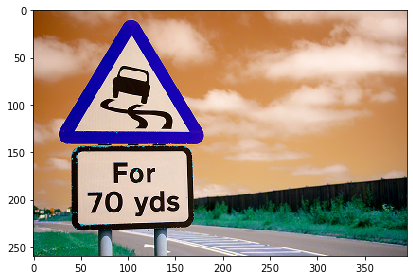

In [5]:
img = cv2.imread(filename=INPUT_PATH+fname+'.jpg')
showimage(img)

In [6]:
model = "../models/frozen_east_text_detection.pb"
net = cv2.dnn.readNet(model)
print(net)

height_ = img.shape[0]
width_ = img.shape[1]
rW = width_ / float(inpWidth)
rH = height_ / float(inpHeight)


<dnn_Net 000002107E6573D0>


#### Create blob from the image

In [15]:
blob = cv2.dnn.blobFromImage(img,1.0,(320,320),(123.68,116.70,103.94), True, False)

outputLayers = []
outputLayers.append("feature_fusion/Conv_7/Sigmoid")
outputLayers.append("feature_fusion/concat_3")


net.setInput(blob)
output = net.forward(outputLayers)

scores = output[0]
geometry = output[1]

print(scores)
print("---------------")
print(geometry)

[[[[4.6626099e-08 2.9893801e-07 1.4357822e-06 ... 3.5590645e-07
    1.3535524e-07 1.7935330e-06]
   [1.1760092e-07 2.0412027e-07 1.0166895e-06 ... 1.8150000e-06
    8.1521466e-07 3.4202662e-06]
   [2.8527850e-08 3.4538918e-08 2.8333611e-06 ... 2.9115879e-06
    3.9757393e-07 5.2011478e-06]
   ...
   [1.2290308e-06 7.8220239e-07 8.2208345e-07 ... 5.0263896e-08
    1.3843818e-09 4.3094256e-10]
   [1.4616186e-06 7.7702174e-07 1.5302167e-07 ... 2.9505930e-08
    1.6350630e-09 4.9042419e-09]
   [6.9987641e-07 7.3860946e-08 1.0733241e-08 ... 8.8628367e-09
    4.5078332e-09 6.8966427e-10]]]]
---------------
[[[[ 1.63766327e+02  1.23625229e+02  1.33501160e+02 ...  1.39804031e+02
     1.31915329e+02  1.61350037e+02]
   [ 1.31790665e+02  7.40585480e+01  7.89611053e+01 ...  8.57816086e+01
     8.29142838e+01  1.21938522e+02]
   [ 1.37828018e+02  7.51481247e+01  7.94219666e+01 ...  9.82190933e+01
     9.60927429e+01  1.32969742e+02]
   ...
   [ 1.40197922e+02  1.00009354e+02  1.09910812e+02 ...  3

In [17]:
[boxes, confidences] = decode(scores, geometry, confThreshold)

indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, confThreshold, nmsThreshold)

print(boxes)

print(confidences)

print(indices)

[]
[]
()


#### Overlay image with detected boxes

In [9]:
for i in indices:
    # get 4 corners of the rotated rect
    vertices = cv2.boxPoints(boxes[i[0]])
    # scale the bounding box coordinates based on the respective ratios
    for j in range(4):
        vertices[j][0] *= rW
        vertices[j][1] *= rH
    for j in range(4):
        p1 = (vertices[j][0], vertices[j][1])
        p2 = (vertices[(j + 1) % 4][0], vertices[(j + 1) % 4][1])
        cv2.line(img, p1, p2, (0, 255, 0), 2, cv2.LINE_AA)
        # cv.putText(frame, "{:.3f}".format(confidences[i[0]]), (vertices[0][0], vertices[0][1]), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv.LINE_AA)

#### Show image

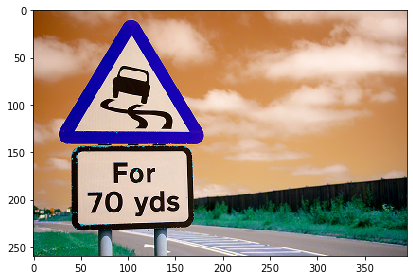

In [10]:
showimage(img)

#### Write the output image(s)

In [11]:
print('Writing image...')
_ = cv2.imwrite(img=img,filename=OUTPUT_PATH+fname+'-detected.jpg')

Writing image...


#### Remove any stray image windows

In [12]:
cv2.destroyAllWindows()